# Diabetes Classification using Dense Layers

In [87]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [88]:
torch.manual_seed(42)
np.random.seed(42)

In [89]:
data = pd.read_csv('data/diabetes.csv')

X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [90]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [91]:
class DiabetesNet(nn.Module):
    def __init__(self, input_size):
        super(DiabetesNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.fc4 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [92]:
net = DiabetesNet(input_size=X_train.shape[1])
print(net)

DiabetesNet(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [93]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [94]:
num_epochs = 10
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = net(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/10], Train Accuracy: 0.7230, Validation Accuracy: 0.7724


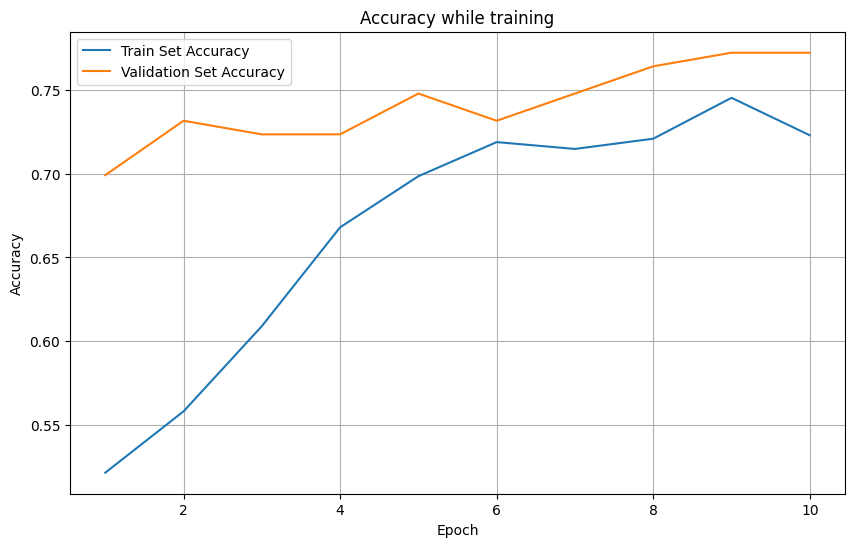

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [96]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f'Test Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, predicted))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predicted))

Test Accuracy: 0.7078
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        99
           1       0.58      0.67      0.62        55

    accuracy                           0.71       154
   macro avg       0.69      0.70      0.69       154
weighted avg       0.72      0.71      0.71       154

Confusion Matrix:
[[72 27]
 [18 37]]
